See: https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2

In [1]:
import cv2
import numpy as np
from IPython.display import Image

In [2]:
import glob
glob.glob("../../Images/*")

['../../Images\\1.png',
 '../../Images\\1_500x500.png',
 '../../Images\\2.png',
 '../../Images\\3.png',
 '../../Images\\4.png',
 '../../Images\\5.png',
 '../../Images\\6.jpeg',
 '../../Images\\datasheet_sample.png',
 '../../Images\\sudoku-original.jpg',
 '../../Images\\test.jpg']

In [3]:
def showImg(title, image):
    cv2.imshow(title, image)
    
    # For Jupyter Notebook support
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [44]:
# See: https://gist.github.com/mineshpatel1/22e86200eee86ebe3e221343b26fc3f3#file-display_points-py
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()

    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    showImg("Display Points", img)
    return img

In [37]:
def plot_many_images(images, titles, rows=1, columns=2):
    """Plots each image in a given list in a grid format using Matplotlib."""
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()

In [50]:
def display_rects(in_img, rects, colour=255):
    """Displays rectangles on the image."""
    img = in_img.copy()
    for rect in rects:
        img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
    showImg("Display Rectangles", img)
    return img

In [53]:
def show_digits(digits, colour=255):
    """Shows list of 81 extracted digits in a grid format"""
    rows = []
    with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
    for i in range(9):
        row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
        rows.append(row)
    showImg("Show Digits", np.concatenate(rows))

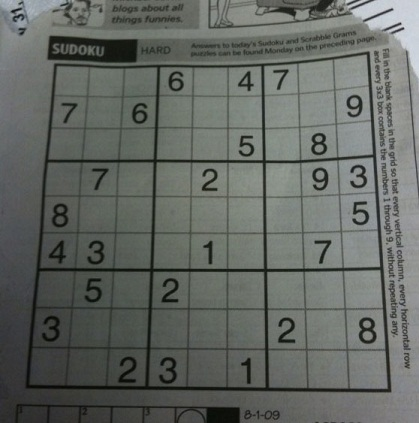

In [4]:
file_path = '../../Images/sudoku-original.jpg'
Image(file_path)

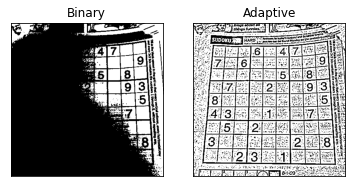

In [39]:
from matplotlib import pyplot as plt

img = cv2.imread(file_path, cv2.IMREAD_COLOR)
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Binary global threshold using a value of 127
ret, threshold1 = cv2.threshold(grayscale, 127, 255, cv2.THRESH_BINARY)

# Binary adaptive threshold using 11 nearest neighbour pixels
threshold2 = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# showImg("Binary", threshold1)
# showImg("Adaptive", threshold2)
plot_many_images([threshold1, threshold2], ['Binary', 'Adaptive'])

In [26]:
def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines.
#         kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        proc = cv2.dilate(proc, kernel, iterations=1)

    return proc

In [41]:
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img, skip_dilate=False)
showImg("Processed", processed)

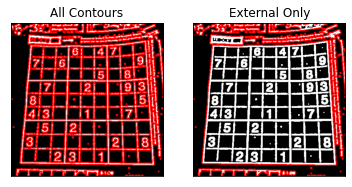

In [42]:
# Find the contours in the image
# cv2.RETR_TREE indicates how the contours will be retrieved:
# See: https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
#
# cv2.CHAIN_APPROX_SIMPLE condenses the contour information, only storing the minimum number of points to describe
# the contour shape.
ext_contours, hier = cv2.findContours(processed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, hier = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

# Draw all of the contours on the image in 2px red lines
all_contours = cv2.drawContours(processed.copy(), contours, -1, (255, 0, 0), 2)
external_only = cv2.drawContours(processed.copy(), ext_contours, -1, (255, 0, 0), 2)

# showImg("All Contours", all_contours)
# showImg("External Only", external_only)

plot_many_images([all_contours, external_only], ['All Contours', 'External Only'])

In [32]:
import operator

def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [45]:
# Doing everything together now
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img)
corners = find_corners_of_largest_polygon(processed)
print(corners)
display_points(processed, corners)

[array([53, 63], dtype=int32), array([370,  51], dtype=int32), array([391, 393], dtype=int32), array([ 25, 389], dtype=int32)]


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [46]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [47]:
original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
showImg("Cropped", cropped)

In [48]:
def infer_grid(img):
    """Infers 81 cell grid from a square image."""
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for i in range(9):
        for j in range(9):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

In [51]:
original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
squares = infer_grid(cropped)

display_rects(cropped, squares)

array([[255, 255, 255, ..., 255, 255, 255],
       [255,  75,  56, ...,  60,  95, 136],
       [255,  68,  46, ...,  51,  88, 138],
       ...,
       [255,  22,  16, ...,  42,  42,  88],
       [255,  36,  33, ...,  84,  86, 107],
       [255,  50,  50, ..., 128, 125, 128]], dtype=uint8)

In [52]:
def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))


def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    """
    Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
    connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
    """
    img = inp_img.copy()  # Copy the image, leaving the original untouched
    height, width = img.shape[:2]

    max_area = 0
    seed_point = (None, None)

    if scan_tl is None:
        scan_tl = [0, 0]

    if scan_br is None:
        scan_br = [width, height]

    # Loop through the image
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            # Only operate on light or white squares
            if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid
                    max_area = area[0]
                    seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

    # Highlight the main feature
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)

            # Find the bounding parameters
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point


def extract_digit(img, rect, size):
    """Extracts a digit (if one exists) from a Sudoku square."""

    digit = cut_from_rect(img, rect)  # Get the digit box from the whole square

    # Use fill feature finding to get the largest feature in middle of the box
    # Margin used to define an area in the middle we would expect to find a pixel belonging to the digit
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)

    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

def get_digits(img, squares, size):
    """Extracts digits from their cells and builds an array"""
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True)
    for square in squares:
        digits.append(extract_digit(img, square, size))
    return digits

In [57]:
original = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(original)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(original, corners)
squares = infer_grid(cropped)
digits = get_digits(cropped, squares, 28)

# See https://gist.github.com/mineshpatel1/22e86200eee86ebe3e221343b26fc3f3#file-show_digits-py
show_digits(digits)